
## Image classifier for the SVHN dataset


We created a neural network that classifies real-world images digits.

Importing all the neccessary libraries

In [1]:
import tensorflow as tf
from scipy.io import loadmat

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

For the project, we used the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, we had two files: `train_32x32.mat` and `test_32x32.mat` which were stored in Drive for use in this Colab notebook.

Our goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Connect to Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Load the dataset from Drive folder

# train = loadmat('path/to/train_32x32.mat')
# test = loadmat('path/to/test_32x32.mat')

train = loadmat('/content/gdrive/My Drive/Colab Notebooks/PROJECTS/Image Classifier for the SVHN Dataset/train_32x32.mat')
test = loadmat('/content/gdrive/My Drive/Colab Notebooks/PROJECTS/Image Classifier for the SVHN Dataset/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset


In [5]:
# Extracting the training and testing images and labels separately from the train and test dictionaries.

X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']

X_train.shape, X_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [6]:
# Selecting a random sample of images and corresponding labels from the dataset (at least 10), and displaying them in a figure.

y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


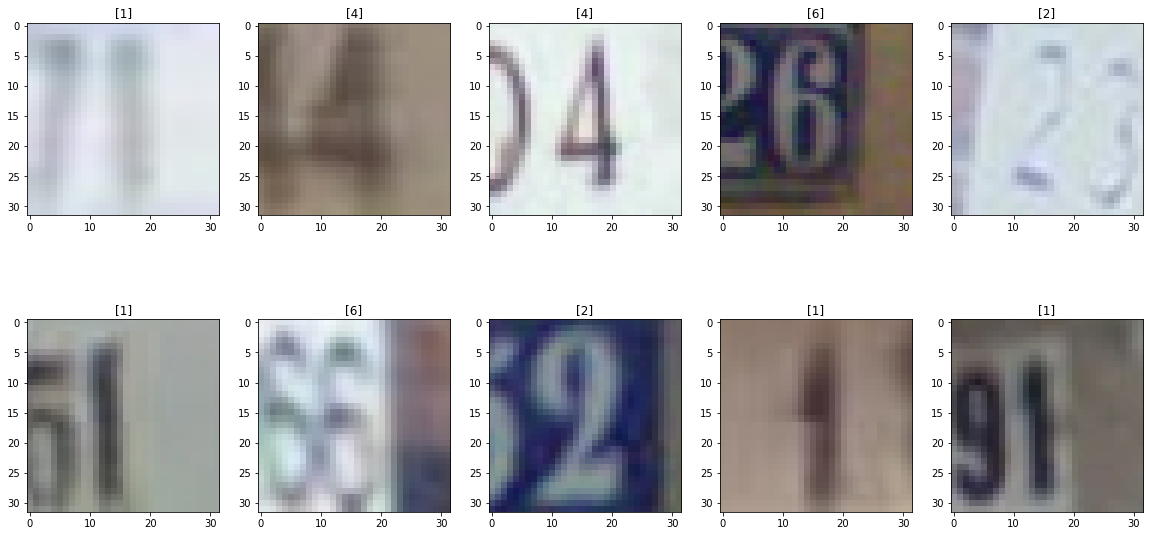

In [7]:
import random

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    n=random.randint(0,X_train.shape[3])
    plt.imshow(X_train[:, :, :,n])
    plt.title(y_train[n])
    
plt.show()

In [8]:
# Converting the training and test images to grayscale by taking the average across all colour channels for each pixel. 

X_train_gs=np.zeros((X_train.shape[3],X_train.shape[0],X_train.shape[1],1))
for i in range(X_train.shape[3]):
    X_train_gs[i,:,:,0]=np.average(X_train[:,:,:,i],axis=2)
                        #(X_train[:,:,0,i]+X_train[:,:,1,i]+X_train[:,:,2,i])/3.0

X_train_gs = X_train_gs/255.

X_test_gs=np.zeros((X_test.shape[3],X_test.shape[0],X_test.shape[1],1))
for i in range(X_test.shape[3]):
    X_test_gs[i,:,:,0]=np.average(X_test[:,:,:,i],axis=2)
                       #(X_test[:,:,0,i]+X_test[:,:,1,i]+X_test[:,:,2,i])/3.0

X_test_gs = X_test_gs/255.

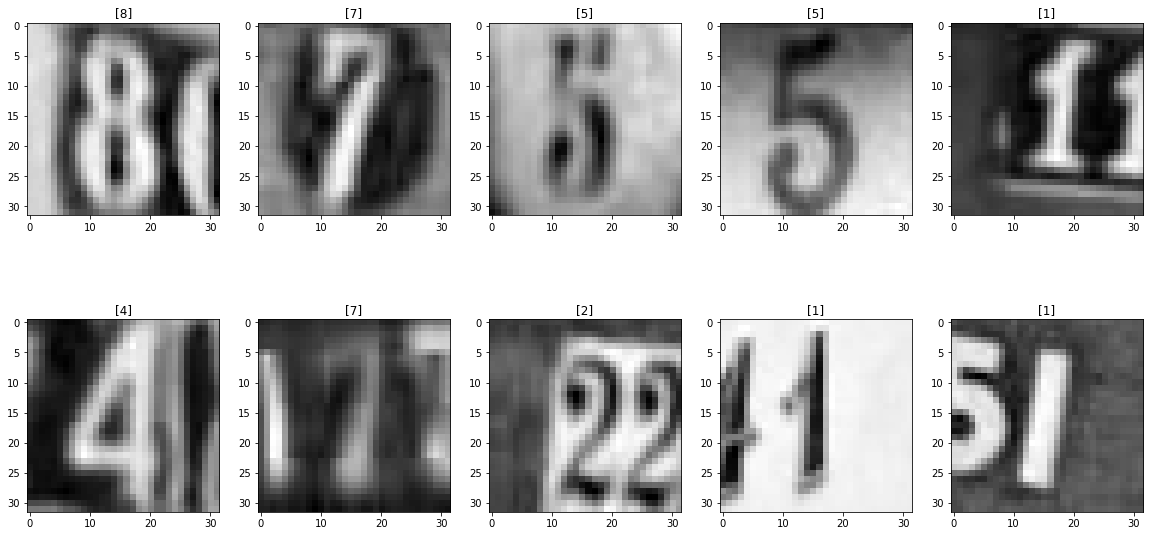

In [9]:
# Selecting a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and displaying them in a figure.

import random

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    n=random.randint(0,X_train.shape[3])
    plt.imshow(X_train_gs[n,:,:,0],cmap=plt.get_cmap('gray'))
    plt.title(y_train[n])
    
plt.show()

## 2. MLP neural network classifier


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax 

In [11]:
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)
X_train.shape 


(73257, 32, 32, 3)

In [12]:
X_train[0].shape 

(32, 32, 3)

In [13]:
# Building an MLP classifier model using the Sequential API using only Flatten and Dense layers, with the final layer having a 10-way softmax output. 

def get_mlp_model():
    model = Sequential([Flatten(input_shape=X_train[0].shape),
                   Dense(2048,activation='relu'),
                   Dense(2048,activation='relu'),
                   Dense(2048,activation='relu'),
                   #Dense(1024,activation='relu'),
                   #Dense(512,activation='relu'),
                   Dense(10,activation='softmax')])
    return model

# Printing out the model summary 

model = get_mlp_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 2048)              6293504   
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_3 (Dense)             (None, 10)                20490     
                                                                 
Total params: 14,706,698
Trainable params: 14,706,698
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Defining two callbacks during training i.e Early Stopping and Best Checkpoint.

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_best():
    return ModelCheckpoint(filepath='checkpoints_every_epoch/checkpoint_{epoch:03d}',
                          monitor='val_loss',
                          save_weights_only=True,
                          save_best_only=True,
                          verbose=1)

def get_early_stopping():
    return EarlyStopping(patience=4,monitor='loss')
    

checkpoint_best = get_checkpoint_best()
early_stopping = get_early_stopping()


In [15]:
# Clear directory
! rm -r checkpoints_every_epoch

rm: cannot remove 'checkpoints_every_epoch': No such file or directory


In [16]:
# Compiling and training the model making use of both training and validation sets during the training run.

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

callbacks = [checkpoint_best, early_stopping]
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.15, callbacks=callbacks, verbose=1)

Epoch 1/30
485/487 [============================>.] - ETA: 0s - loss: 43.6617 - accuracy: 0.3032
Epoch 1: val_loss improved from inf to 1.54919, saving model to checkpoints_every_epoch/checkpoint_001
487/487 [==============================] - 13s 17ms/step - loss: 43.5344 - accuracy: 0.3038 - val_loss: 1.5492 - val_accuracy: 0.5021
Epoch 2/30
486/487 [============================>.] - ETA: 0s - loss: 1.2562 - accuracy: 0.6006
Epoch 2: val_loss improved from 1.54919 to 1.26725, saving model to checkpoints_every_epoch/checkpoint_002
487/487 [==============================] - 5s 10ms/step - loss: 1.2564 - accuracy: 0.6005 - val_loss: 1.2673 - val_accuracy: 0.5867
Epoch 3/30
480/487 [============================>.] - ETA: 0s - loss: 1.0944 - accuracy: 0.6590
Epoch 3: val_loss improved from 1.26725 to 1.13981, saving model to checkpoints_every_epoch/checkpoint_003
487/487 [==============================] - 4s 8ms/step - loss: 1.0933 - accuracy: 0.6593 - val_loss: 1.1398 - val_accuracy: 0.65

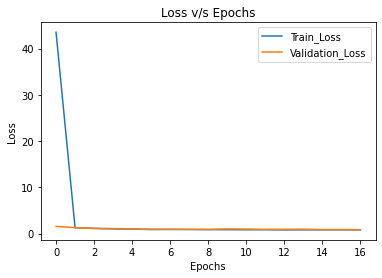

In [17]:
# Plotting the learning curves for loss vs epoch for both training and validation sets.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_Loss','Validation_Loss'], loc='upper right')
plt.title("Loss v/s Epochs")
plt.show()

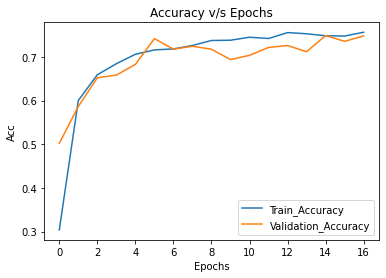

In [18]:
# Plotting the learning curves for accuracy vs epoch for both training and validation sets.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Train_Accuracy','Validation_Accuracy'], loc='lower right')
plt.title("Accuracy v/s Epochs")
plt.show()

In [19]:
# Computing and displaying the loss and accuracy of the trained model on the test set.

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")

814/814 [==============================] - 2s 3ms/step - loss: 0.9697 - accuracy: 0.7326
Test Loss is 0.9697173833847046
Test Accuracy is 0.7325983643531799


## 3. CNN neural network classifier


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D , MaxPool2D , BatchNormalization , Dropout

In [21]:
# Building a CNN classifier model using the Sequential API using the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. 
# The final layer has a 10-way softmax output. 

def get_cnn_model():
    model = Sequential([Conv2D(filters=256,kernel_size=3,padding="SAME",activation='relu',input_shape=X_train[0].shape),
                    MaxPool2D(pool_size=(2,2)),
                    Conv2D(filters=128,kernel_size=3,padding="SAME",activation='relu'),
                    MaxPool2D(pool_size=(2,2)),
                    Flatten(),
                    Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5),
                    Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.5),
                    Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    BatchNormalization(),
                    Dense(10,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))])
    return model

model = get_cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [22]:
# # Defining two callbacks during training i.e Early Stopping and Best Checkpoint.

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_best():
    return ModelCheckpoint(filepath='checkpoints_every_epoch_cnn/checkpoint_{epoch:03d}',
                          monitor='val_loss',
                          save_weights_only=True,
                          save_best_only=True,
                          verbose=1)

def get_early_stopping():
    return EarlyStopping(patience=4,monitor='loss')
    

checkpoint_best_cnn = get_checkpoint_best()
early_stopping = get_early_stopping()


In [23]:
# Clear directory
! rm -r checkpoints_every_epoch_cnn

rm: cannot remove 'checkpoints_every_epoch_cnn': No such file or directory


In [24]:
# # Compiling and training the model making use of both training and validation sets during the training run.

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

callbacks = [checkpoint_best_cnn, early_stopping]
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.15, callbacks=callbacks, verbose=1)

Epoch 1/30
487/487 [==============================] - ETA: 0s - loss: 2.8082 - accuracy: 0.1583
Epoch 1: val_loss improved from inf to 2.45616, saving model to checkpoints_every_epoch_cnn/checkpoint_001
487/487 [==============================] - 25s 29ms/step - loss: 2.8082 - accuracy: 0.1583 - val_loss: 2.4562 - val_accuracy: 0.1881
Epoch 2/30
486/487 [============================>.] - ETA: 0s - loss: 2.4293 - accuracy: 0.1791
Epoch 2: val_loss improved from 2.45616 to 2.36496, saving model to checkpoints_every_epoch_cnn/checkpoint_002
487/487 [==============================] - 10s 20ms/step - loss: 2.4293 - accuracy: 0.1791 - val_loss: 2.3650 - val_accuracy: 0.1881
Epoch 3/30
484/487 [============================>.] - ETA: 0s - loss: 2.3453 - accuracy: 0.1831
Epoch 3: val_loss improved from 2.36496 to 2.31235, saving model to checkpoints_every_epoch_cnn/checkpoint_003
487/487 [==============================] - 10s 20ms/step - loss: 2.3452 - accuracy: 0.1830 - val_loss: 2.3123 - val_a

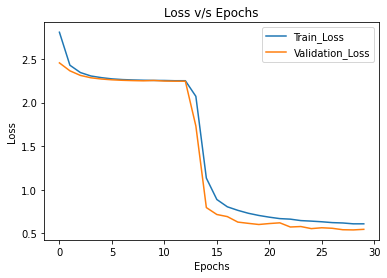

In [25]:
# # Plotting the learning curves for loss vs epoch for both training and validation sets.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train_Loss','Validation_Loss'], loc='upper right')
plt.title("Loss v/s Epochs")
plt.show()

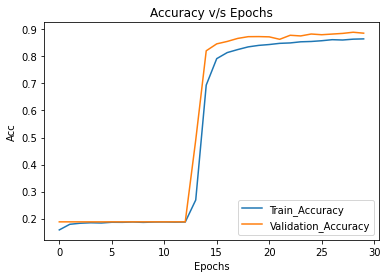

In [26]:
# # Plotting the learning curves for accuracy vs epoch for both training and validation sets.

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Train_Accuracy','Validation_Accuracy'], loc='lower right')
plt.title("Accuracy v/s Epochs")
plt.show()

In [27]:
# # Computing and displaying the loss and accuracy of the trained model on the test set.

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")

814/814 [==============================] - 3s 4ms/step - loss: 0.5916 - accuracy: 0.8750
Test Loss is 0.5916429758071899
Test Accuracy is 0.875


## 4. Get model predictions


In [28]:
! ls -lh checkpoints_every_epoch

total 1.2G
-rw-r--r-- 1 root root   85 Mar 17 13:33 checkpoint
-rw-r--r-- 1 root root 169M Mar 17 13:32 checkpoint_001.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 17 13:32 checkpoint_001.index
-rw-r--r-- 1 root root 169M Mar 17 13:32 checkpoint_002.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 17 13:32 checkpoint_002.index
-rw-r--r-- 1 root root 169M Mar 17 13:32 checkpoint_003.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 17 13:32 checkpoint_003.index
-rw-r--r-- 1 root root 169M Mar 17 13:32 checkpoint_004.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 17 13:32 checkpoint_004.index
-rw-r--r-- 1 root root 169M Mar 17 13:32 checkpoint_005.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 17 13:32 checkpoint_005.index
-rw-r--r-- 1 root root 169M Mar 17 13:32 checkpoint_006.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 17 13:32 checkpoint_006.index
-rw-r--r-- 1 root root 169M Mar 17 13:33 checkpoint_017.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Mar 1

In [29]:
! ls -lh checkpoints_every_epoch_cnn

total 1.2G
-rw-r--r-- 1 root root   85 Mar 17 13:41 checkpoint
-rw-r--r-- 1 root root  54M Mar 17 13:36 checkpoint_001.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 17 13:36 checkpoint_001.index
-rw-r--r-- 1 root root  54M Mar 17 13:36 checkpoint_002.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 17 13:36 checkpoint_002.index
-rw-r--r-- 1 root root  54M Mar 17 13:36 checkpoint_003.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 17 13:36 checkpoint_003.index
-rw-r--r-- 1 root root  54M Mar 17 13:36 checkpoint_004.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 17 13:36 checkpoint_004.index
-rw-r--r-- 1 root root  54M Mar 17 13:37 checkpoint_005.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 17 13:37 checkpoint_005.index
-rw-r--r-- 1 root root  54M Mar 17 13:37 checkpoint_006.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 17 13:37 checkpoint_006.index
-rw-r--r-- 1 root root  54M Mar 17 13:37 checkpoint_007.data-00000-of-00001
-rw-r--r-- 1 root root 2.9K Mar 1

In [31]:
# Loading the best weights for the MLP model saved during the training run.

model_val_mlp = get_mlp_model()
model_val_mlp.load_weights(filepath='checkpoints_every_epoch/checkpoint_017')

1/1 [==============================] - 0s 153ms/step


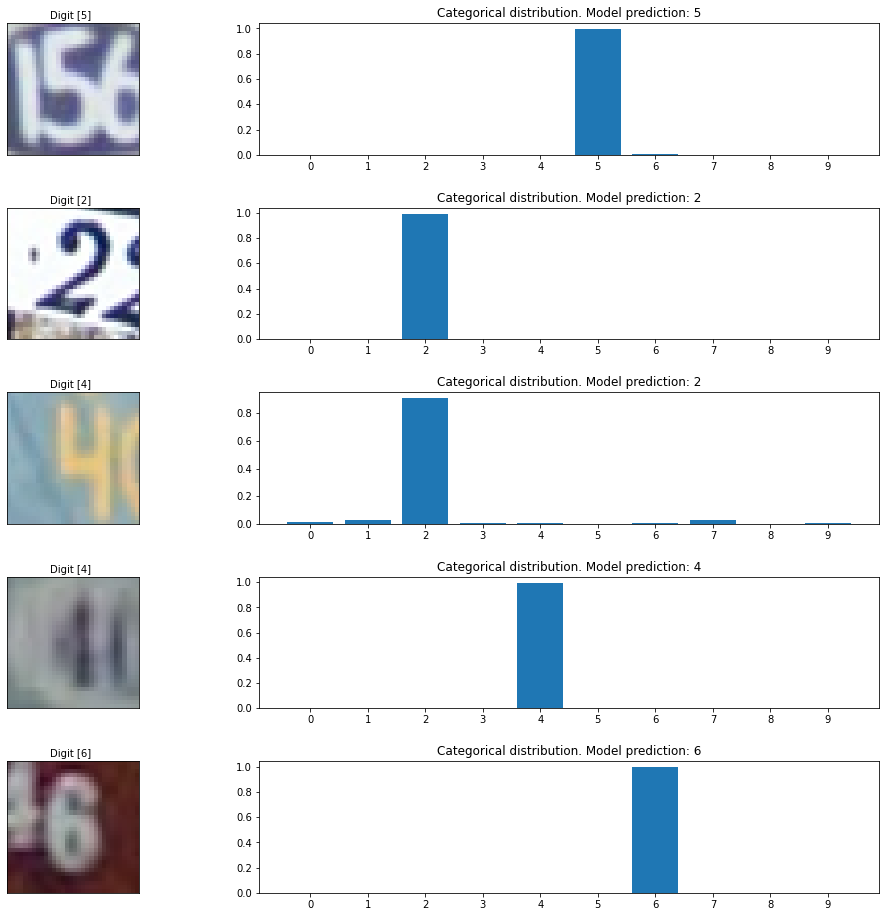

In [32]:
# Randomly selecting 5 images and corresponding labels from the test set and displaying the images with their labels.

num_test_images = X_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_val_mlp.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(20,16))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()

In [33]:
# Loading the best weights for the CNN model saved during the training run.

model_val_cnn= get_cnn_model()
model_val_cnn.load_weights(filepath='checkpoints_every_epoch_cnn/checkpoint_029')

1/1 [==============================] - 0s 158ms/step


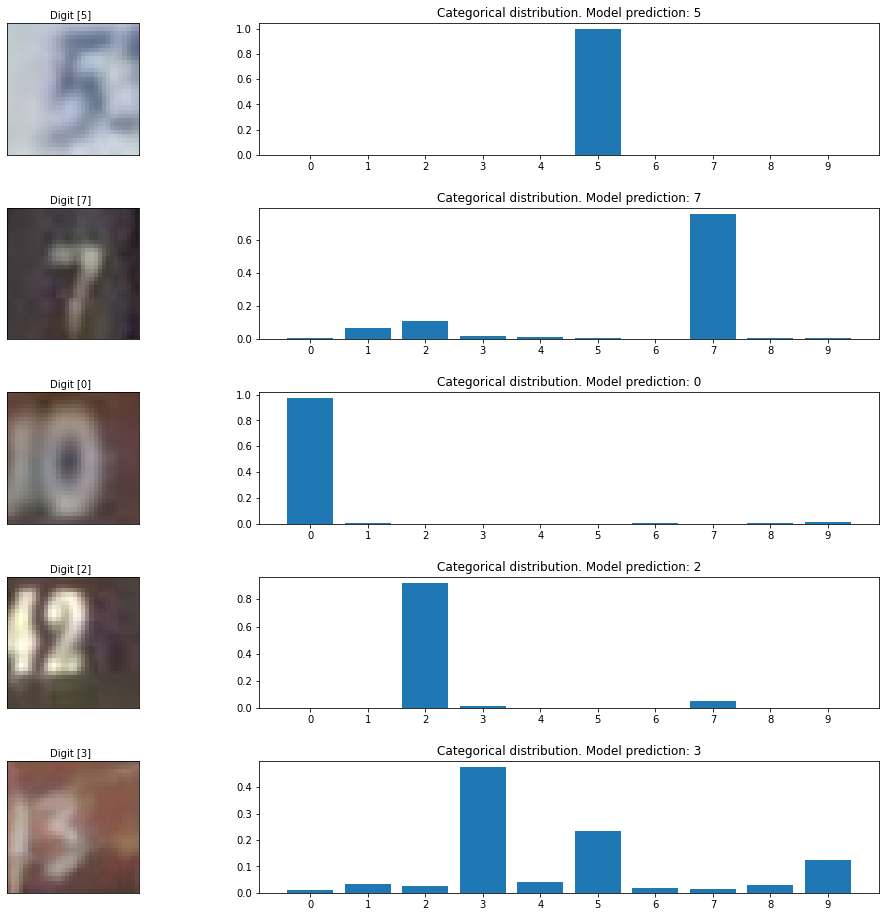

In [34]:
# Randomly selecting 5 images and corresponding labels from the test set and displaying the images with their labels.

num_test_images = X_test.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model_val_cnn.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(20, 16))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()